<a href="https://colab.research.google.com/github/Rajora0/avaliacao_daedalus/blob/main/question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 'https://drive.google.com/uc?export=download&id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h'
!gdown 'https://drive.google.com/uc?export=download&id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM'

Downloading...
From: https://drive.google.com/uc?export=download&id=1Jg8FPCxGPckXMNSlTybxFu5unZCFuW9h
To: /content/KITTI-Sequence.zip
100% 18.0M/18.0M [00:00<00:00, 48.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=10rYRFQAi1AlJDSWAoZK7-SX0D8Kr2oDM
To: /content/ground_truth.npy
100% 3.97k/3.97k [00:00<00:00, 10.7MB/s]


In [ ]:
!rm -rf objects

In [ ]:
%%bash
mkdir data
mkdir objects
unzip -q KITTI-Sequence.zip -d  data/ 
mv data/*/*.obj objects
rm KITTI-Sequence.zip
rm -rf data

In [ ]:
!ls objects

000000_points.obj  000008_points.obj  000016_points.obj  000024_points.obj
000001_points.obj  000009_points.obj  000017_points.obj  000025_points.obj
000002_points.obj  000010_points.obj  000018_points.obj  000026_points.obj
000003_points.obj  000011_points.obj  000019_points.obj  000027_points.obj
000004_points.obj  000012_points.obj  000020_points.obj  000028_points.obj
000005_points.obj  000013_points.obj  000021_points.obj  000029_points.obj
000006_points.obj  000014_points.obj  000022_points.obj
000007_points.obj  000015_points.obj  000023_points.obj


In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.5/681.5 kB 16.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
ground_truth_transformation = np.load("ground_truth.npy")

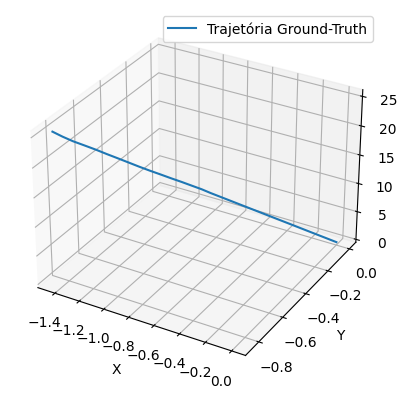

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_ground_truth = ground_truth_transformation[:, 0, 3]
y_ground_truth = ground_truth_transformation[:, 1, 3]
z_ground_truth = ground_truth_transformation[:, 2, 3]

ax.plot(x_ground_truth, y_ground_truth, z_ground_truth, label="Trajetória Ground-Truth")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

# OPEN3D 

In [ ]:
!pip install open3d -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.5 MB/s eta 0:00:00


In [ ]:
import os
import trimesh
import numpy as np
import open3d as o3d
from tqdm import tqdm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def load_point_cloud(file_path):
    """Carrega uma nuvem de pontos de um arquivo .obj usando Open3D."""
    mesh = trimesh.load_mesh(file_path)
    point_cloud = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(mesh.vertices))
    return point_cloud

In [ ]:
point_cloud_folder = "objects"
point_cloud_files = sorted(os.listdir(point_cloud_folder))

point_clouds = []
for file in tqdm(point_cloud_files, desc='point_clouds'):
    point_clouds.append(load_point_cloud(os.path.join(point_cloud_folder, file)))

point_clouds: 100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


In [ ]:
def estimate_trajectory_icp(source, target, max_iter=50, tol=1e-6):
    """
    Estima a matriz de transformação utilizando o algoritmo ICP da biblioteca Open3D.
    """
    criteria = o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter,
                                                                  relative_fitness=tol)
    result = o3d.pipelines.registration.registration_icp(source, target,
                                                          max_correspondence_distance=tol,
                                                          init=np.eye(4),
                                                          estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                                                          criteria=criteria)
    return result.transformation

In [ ]:
trajectory_open3d = [np.eye(4)]
for idx in tqdm(range(len(point_clouds) - 1), desc='trajectory_open3d'):
    transformation = estimate_trajectory_icp(point_clouds[idx], point_clouds[idx + 1])
    trajectory_open3d.append(trajectory_open3d[-1] @ transformation)

trajectory_open3d = np.array(trajectory_open3d)

trajectory_open3d: 100%|██████████| 29/29 [00:06<00:00,  4.81it/s]


In [ ]:
error_open3d = np.mean(np.sum((trajectory_open3d - (ground_truth_transformation / np.amax(ground_truth_transformation))) ** 2, axis=(-1, -2)))
print("Erro médio de transformação com Open3D: ", error_open3d)

Erro médio de transformação com Open3D:  4.024374499963235


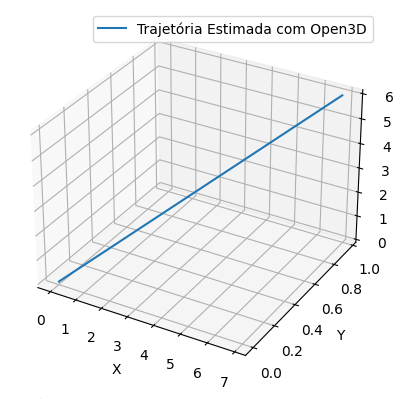

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = trajectory_open3d[:, 0, 3]
y = trajectory_open3d[:, 1, 3]
z = trajectory_open3d[:, 2, 3]

ax.plot(x, y, z, label="Trajetória Estimada com Open3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

# Original ICP

In [ ]:
import trimesh
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def load_point_cloud(file_path):
    """Carrega uma nuvem de pontos de um arquivo .obj usando trimesh."""
    mesh = trimesh.load_mesh(file_path)
    point_cloud = np.asarray(mesh.vertices)
    return point_cloud

In [ ]:
point_cloud_folder = "objects"
point_cloud_files = sorted(os.listdir(point_cloud_folder))

point_clouds = []
for file in tqdm(point_cloud_files):
    point_clouds.append(load_point_cloud(os.path.join(point_cloud_folder, file)))

100%|██████████| 30/30 [00:06<00:00,  4.81it/s]


In [ ]:
class ICPConvergenceCriteria:
    def __init__(self, max_iteration=50, relative_fitness=1e-6):
        self.max_iteration = max_iteration
        self.relative_fitness = relative_fitness

def find_correspondences(source_transformed, target, max_correspondence_distance):
    tree = cKDTree(target)
    distances, indices = tree.query(source_transformed, distance_upper_bound=max_correspondence_distance)
    
    valid_indices = indices != tree.n
    target_correspondence = target[indices[valid_indices]]
    source_correspondence = source_transformed[valid_indices]
    
    return source_correspondence, target_correspondence, distances[valid_indices]

def compute_point_to_point_transformation(source_correspondence, target_correspondence):
    mean_source = np.mean(source_correspondence, axis=0)
    mean_target = np.mean(target_correspondence, axis=0)

    H = np.dot((source_correspondence - mean_source).T, (target_correspondence - mean_target))
    U, _, V = np.linalg.svd(H)
    R = np.dot(U, V)
    t = mean_target - np.dot(R, mean_source)

    delta_transformation = np.eye(4)
    delta_transformation[:3, :3] = R
    delta_transformation[:3, 3] = t
    
    return delta_transformation

def registration_icp(source, target, max_correspondence_distance=1e-6,
                     init=np.eye(4), estimation_method="point_to_point",
                     criteria=ICPConvergenceCriteria()):
    transformation = init
    prev_error = np.inf

    for _ in range(criteria.max_iteration):
        # Etapa 3: Estimativa de correspondências
        source_transformed = np.dot(source, transformation[:3, :3].T) + transformation[:3, 3]
        source_correspondence, target_correspondence, valid_distances = find_correspondences(source_transformed, target, max_correspondence_distance)

        if len(source_correspondence) == 0 or len(target_correspondence) == 0:
            print("No corresponding points found. Exiting ICP loop.")
            break

        # Etapa 4: Estimativa de transformação
        if estimation_method == "point_to_point":
            delta_transformation = compute_point_to_point_transformation(source_correspondence, target_correspondence)
            transformation = np.dot(delta_transformation, transformation)
        else:
            raise NotImplementedError("Only 'point_to_point' estimation method is implemented")

        # Etapa 6: Atualizar erro e condição de parada
        error = np.mean(valid_distances)
        delta_error = prev_error - error
        prev_error = error
        
        if delta_error < criteria.relative_fitness:
            break

    return transformation

In [ ]:
# Parâmetros para o ICP
max_iter = 50
tol = 1e-6
criteria = ICPConvergenceCriteria(max_iteration=max_iter, relative_fitness=tol)

# Calcular as transformações de cada nuvem de pontos em relação à primeira nuvem de pontos
transformations = [np.eye(4)]  # A transformação da primeira nuvem de pontos é a matriz identidade
for i in tqdm(range(1, len(point_clouds))):
    source = point_clouds[i]
    target = point_clouds[0]
    transform = registration_icp(source, target, criteria=criteria)
    transformations.append(transform)

 14%|█▍        | 4/29 [00:01<00:05,  4.19it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 21%|██        | 6/29 [00:01<00:05,  4.42it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 28%|██▊       | 8/29 [00:01<00:03,  6.09it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 34%|███▍      | 10/29 [00:02<00:02,  6.58it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 38%|███▊      | 11/29 [00:02<00:02,  6.65it/s]

No corresponding points found. Exiting ICP loop.


 52%|█████▏    | 15/29 [00:02<00:02,  6.68it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 59%|█████▊    | 17/29 [00:03<00:01,  8.02it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 72%|███████▏  | 21/29 [00:03<00:00,  9.92it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 79%|███████▉  | 23/29 [00:03<00:00, 10.34it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


 93%|█████████▎| 27/29 [00:03<00:00, 11.17it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]

No corresponding points found. Exiting ICP loop.
No corresponding points found. Exiting ICP loop.


In [ ]:
transformations_array = np.array(transformations)
ground_truth_norm = ground_truth_transformation / np.amax(ground_truth_transformation)

In [ ]:
# Calcular o erro médio
error = np.mean(np.sum((transformations_array - ground_truth_norm) ** 2, axis=(-1, -2)))
print("Erro médio de transformação Original ICP: ", error)

Erro médio de transformação Original ICP:  4.024378985834185


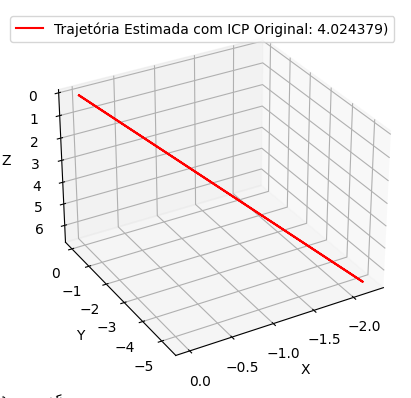

In [ ]:
# Criar a figura e a projeção 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Trajetória estimada (transformations)
x = transformations_array[:, 0, 3]
y = transformations_array[:, 1, 3]
z = transformations_array[:, 2, 3]

ax.view_init(elev=-150, azim=120)
ax.plot(x, y, z, color='red', label=f"Trajetória Estimada com ICP Original: {error:.6f})")

# Configurando os rótulos e a legenda
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()